
Class distribution in Training set:
Class 0: 2832 samples
Class 1: 7354 samples

Class distribution in Test set:
Class 0: 1214 samples
Class 1: 3152 samples

✔️ Class distribution between Train and Test sets is similar.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.5059 - loss: 4.8605 - val_accuracy: 0.7219 - val_loss: 3.3179 - learning_rate: 5.0000e-04
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7165 - loss: 2.9732 - val_accuracy: 0.7219 - val_loss: 2.2420 - learning_rate: 5.0000e-04
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7873 - loss: 1.9091 - val_accuracy: 0.7116 - val_loss: 1.6904 - learning_rate: 5.0000e-04
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8576 - loss: 1.2711 - val_accuracy: 0.7219 - val_loss: 1.3031 - learning_rate: 5.0000e-04
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8665 - loss: 0.9255 - val_accuracy: 0.7529 - val_loss: 0.8787 - learning_rate: 5.0000e-04
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8847 - loss: 0.6870 - val_accuracy: 0.8191 - val_loss: 0.7247 - learning_rate: 5.0000e-04
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - ac

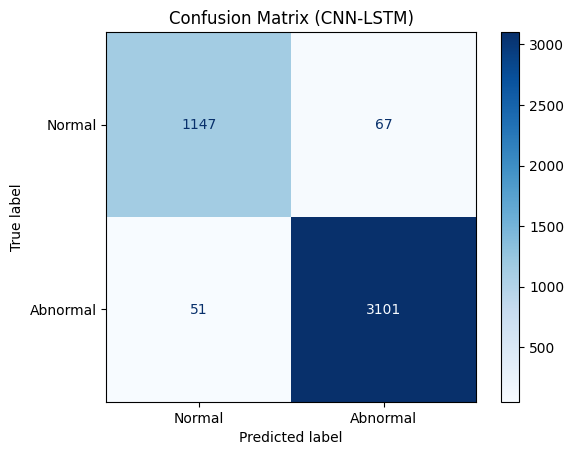

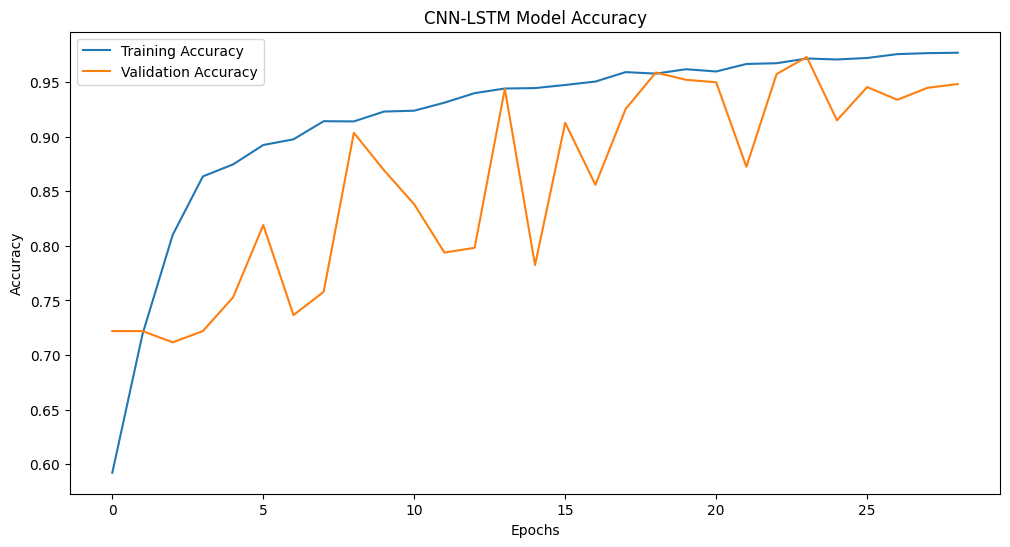

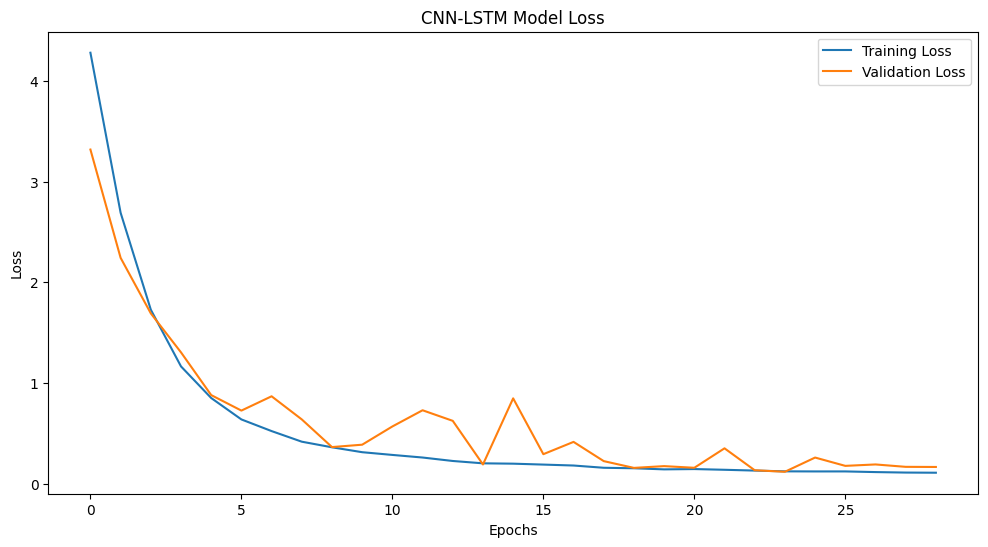

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to check data split
def check_data_split(X_train, X_test, y_train, y_test):
    intersection = np.intersect1d(X_train.flatten(), X_test.flatten())
    if len(intersection) > 0:
        print("Warning: There is overlap between training and test sets!")
    else:
        print("\u2714\ufe0f No overlap between training and test sets.")

    train_classes, train_counts = np.unique(y_train, return_counts=True)
    print("\nClass distribution in Training set:")
    for cls, count in zip(train_classes, train_counts):
        print(f"Class {cls}: {count} samples")

    test_classes, test_counts = np.unique(y_test, return_counts=True)
    print("\nClass distribution in Test set:")
    for cls, count in zip(test_classes, test_counts):
        print(f"Class {cls}: {count} samples")

    train_distribution = train_counts / len(y_train)
    test_distribution = test_counts / len(y_test)
    if np.allclose(train_distribution, test_distribution, atol=0.05):
        print("\n\u2714\ufe0f Class distribution between Train and Test sets is similar.")
    else:
        print("\nWarning: Class distribution between Train and Test sets differs significantly!")

# Load data
normal_data = pd.read_csv('ptbdb_normal.csv', header=None)
abnormal_data = pd.read_csv('ptbdb_abnormal.csv', header=None)

# Remove the last column
normal_data = normal_data.drop(columns=[normal_data.columns[-1]])
abnormal_data = abnormal_data.drop(columns=[abnormal_data.columns[-1]])

# Add labels
normal_data['label'] = 0
abnormal_data['label'] = 1

# Combine data
data = pd.concat([normal_data, abnormal_data], axis=0).reset_index(drop=True)

# Split features and labels
X = data.iloc[:, :-1].values
y = data['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
check_data_split(X_train, X_test, y_train, y_test)

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define CNN-LSTM model
model_cnn_lstm = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

# Evaluate model
loss_cnn_lstm, accuracy_cnn_lstm = model_cnn_lstm.evaluate(X_test, y_test)
print(f'Test Accuracy with CNN-LSTM: {accuracy_cnn_lstm * 100:.2f}%')

# Predictions and confusion matrix
y_pred_cnn_lstm = (model_cnn_lstm.predict(X_test) > 0.5).astype(int)
print("\nClassification Report (CNN-LSTM):")
print(classification_report(y_test, y_pred_cnn_lstm))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (CNN-LSTM)")
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_cnn_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN-LSTM Model Accuracy')
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history_cnn_lstm.history['loss'], label='Training Loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN-LSTM Model Loss')
plt.show()
